In [1]:
import numpy as np
import pylab as pl

In [2]:
N = 5000
box_xrange = (-10, 10)
box_yrange = (-10, 10)
starting_radius = 0.1

In [3]:
coords = (np.random.random((10*N, 2)) - 0.5)*2 * starting_radius # Between -starting_radius and starting_radius
coords = coords[(coords**2).sum(axis=1) < starting_radius**2][:N]

assert len(coords) == N, "I tried generating 10x more points in a square and taking then only those in a circle, but it wasn't enough. Try increasing the factor"

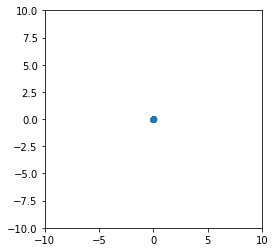

In [4]:
ax = pl.subplot(1,1,1)
pl.plot(coords[:,0], coords[:,1], '.')
pl.xlim(box_xrange)
pl.ylim(box_yrange)
ax.set_aspect(1.)
pl.show()

In [5]:
# Run simulations
import tqdm
num_steps = 10000
random_step=0.01

trajectory = [coords]
for i in tqdm.tqdm(range(num_steps)):
    random_displacement = (np.random.random((N, 2)) - 0.5)*2 * random_step
    new_positions = trajectory[-1] + random_displacement
    # Some points might have gone beyond the box.
    # I could either reflect them back as a hard wall, or just use PBC. For simplicity, I use PBC
    new_positions[:,0] = (new_positions[:,0] - box_xrange[0]) % (box_xrange[1] - box_xrange[0]) + box_xrange[0]
    new_positions[:,1] = (new_positions[:,1] - box_yrange[0]) % (box_yrange[1] - box_yrange[0]) + box_yrange[0]    
    trajectory.append(new_positions)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:03<00:00, 2798.17it/s]


In [6]:
import ipywidgets as ipw

@ipw.interact(
    frame_idx=ipw.IntSlider(description='Frame', min=0, max=num_steps-1, value=0, continuous_update=False)
)
def plot(frame_idx):
    frame_coords = trajectory[frame_idx]
    pl.figure()
    ax = pl.subplot(1,1,1)
    pl.plot(frame_coords[:,0], frame_coords[:,1], '.')
    
    std_radius = np.array(frame_coords).std(axis=0).mean()
    circle = pl.Circle((0, 0), 2*std_radius, color='b', fill=False)
    ax.add_patch(circle)
    
    pl.xlim(box_xrange)
    pl.ylim(box_yrange)
    ax.set_aspect(1.)
    pl.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='Frame', max=9999), Output()), _…

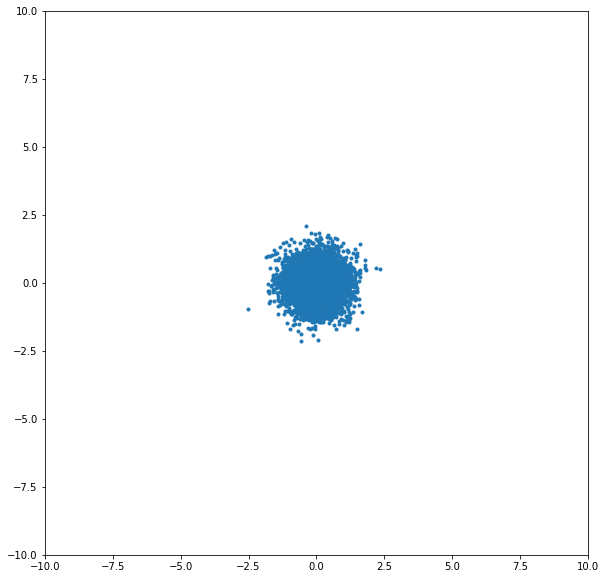

In [17]:
from matplotlib import animation

fps = 25
video_length_seconds = 10.
num_video_frames = int(fps*video_length_seconds)

fig_movie = pl.figure(figsize=(10,10))
ax = pl.subplot(1,1,1)
points_plot = pl.plot(trajectory[0][:,0], trajectory[0][:,1], '.')
circle = pl.Circle((0, 0), 0., color='b', fill=False)
ax.add_patch(circle)
pl.xlim(box_xrange)
pl.ylim(box_yrange)
ax.set_aspect(1.)

def update_frame(frame_idx):
    global trajectory, points_plot, num_video_frames, num_steps, circle
    
    trajectory_idx = frame_idx * (num_steps // num_video_frames)    
    frame_coords = trajectory[trajectory_idx]
    points_plot[0].set_data(frame_coords.T)

    std_radius = np.array(frame_coords).std(axis=0).mean()
    circle.set_radius(2*std_radius)
    
    return points_plot[0], circle

line_ani = animation.FuncAnimation(fig_movie, update_frame, frames=num_video_frames, blit=True)
line_ani.save('diffusion.mp4', fps=fps)

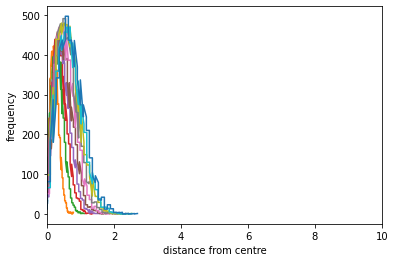

In [18]:
pl.figure()

for frame_idx in [0, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 9999]:
    frame_coords = trajectory[frame_idx]
    radii = np.sqrt((frame_coords**2).sum(axis=1))
    hist_data, hist_x = np.histogram(radii, bins=30)
    hist_coords = np.concatenate([np.array(list(zip(hist_x[:-1], hist_data))), np.array(list(zip(hist_x[1:], hist_data)))])
    hist_coords = hist_coords[hist_coords[:, 0].argsort(), :]
    pl.plot(hist_coords[:, 0], hist_coords[:, 1])
pl.xlim(0, 10)
pl.xlabel("distance from centre")
pl.ylabel("frequency")
pl.show()

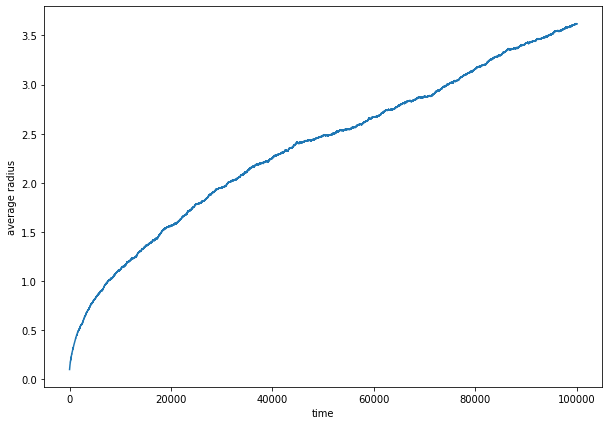

In [9]:
times = []
std_radius = []

pl.figure(figsize=(10,7))

# Do std-deviation for both x and y coords, at each timestep (axis=1 means on all points for that step)
# then do mean on second axis, meaning (x_std + y_std)/2 at each timestep
std_radius = np.array(trajectory).std(axis=1).mean(axis=1)
# TWICE the radius (to match the video)
pl.plot(2*std_radius)

## SLOWER VERSION
#for frame_idx, frame_coords in enumerate(tqdm.tqdm(trajectory)):
#    x_std = frame_coords[:, 0].std()
#    y_std = frame_coords[:, 1].std()
#    std = (x_std + y_std)/2.
#    times.append(frame_idx)
#    std_radius.append(std)
#pl.plot(times, std_radius)

pl.xlabel('time')
pl.ylabel('average radius')
pl.show()

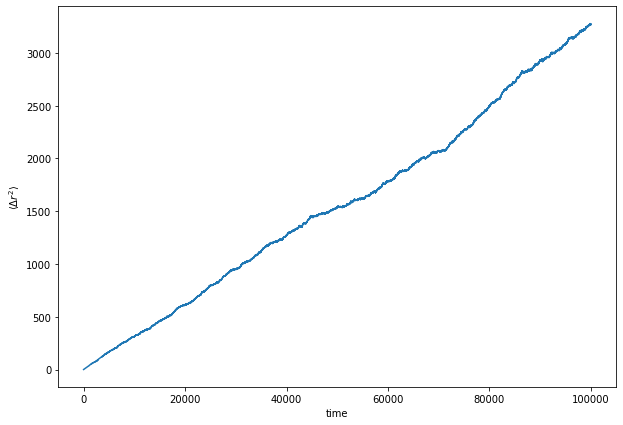

In [12]:
times = []
std_radius = []

pl.figure(figsize=(10,7))

# Do std-deviation for both x and y coords, at each timestep (axis=1 means on all points for that step)
# then do mean on second axis, meaning (x_std + y_std)/2 at each timestep
delta_r2 = ((np.array(trajectory) - np.array(trajectory[0]))**2).sum(axis=(1,2))
# TWICE the radius (to match the video)
pl.plot(delta_r2)

## SLOWER VERSION
#for frame_idx, frame_coords in enumerate(tqdm.tqdm(trajectory)):
#    x_std = frame_coords[:, 0].std()
#    y_std = frame_coords[:, 1].std()
#    std = (x_std + y_std)/2.
#    times.append(frame_idx)
#    std_radius.append(std)
#pl.plot(times, std_radius)

pl.xlabel('time')
pl.ylabel(r'$\langle \Delta r^2\rangle$')
pl.show()
